# Negation Curse

In [2]:
# import all_packages
from utils.calculating_probability import *
torch.cuda.set_device(4)
from utils.all_imports import *

# import model and test_data
model,tokenizer,batch_first= load_model_and_tokenizer("/data/chihan3/cache/llama-2/llama-2-7b-hf",None,4)
hparams = ROMEHyperParams.from_name("llama-7b")
template = Template(name="default")
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

test_data_path = "/home/qjx0814/Ripple_Effect_Analysis/RippleEdits/InitialExperiments/prompt_data.json"
with open(test_data_path,"r") as json_file:
    test_data = json.load(json_file)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# test negation curse at scale: about 1 hour
from tqdm import tqdm
negation_results = [] 
negation_results_path = "negation_overripple_simplified_sentence_results.json"
system_context = "Please simplify the following sentence to make it more easy to understand, here is an example\nOriginal sentence:'The name of the currency in the country of citizenship of Leonardo DiCaprio is'\n Modified sentence:'The currency Leonardo DiCaprio use is'"

all_queris = []
for each_edit in test_data:
    all_queris.extend(each_edit['compositional_I_problems'])

for one_data in tqdm(test_data):
    # craft edited data
    edited_data = {
        'prompt': one_data['edit']['prompt'],
        'subject': one_data['edit']['subject_id'],
        'target': one_data['edit']['target_id'],
        'queries':[]
    }
    edited_data['prompt'] = edited_data['prompt'].replace(" "+ edited_data['subject']+" "," {} ")
    edited_data['prompt'] = edited_data['prompt'].replace(edited_data['target'],"")
    edited_data['prompt'] = edited_data['prompt'].replace('.',"")
    edited_data['prompt'] = edited_data['prompt'].strip()
    
    model_edited, diff_weights = apply_rome_to_model(
        model,
        tokenizer,
        [edited_data],
        hparams,
        batch_first,
        copy=True,
        return_diff_weights=True
    )
    for query in one_data['compositional_I_problems']:
        results_edited = calculate_answer_probability(model_edited,tokenizer,query['compositional_query']['prompt'],[query['compositional_query']['answer']])
        results_not_edited = calculate_answer_probability(model_edited,tokenizer,query['compositional_query']['prompt'] + " not",[query['compositional_query']['answer']])
        results_before = calculate_answer_probability(model,tokenizer,query['compositional_query']['prompt'],[query['compositional_query']['answer']])
        results_not_before = calculate_answer_probability(model,tokenizer,query['compositional_query']['prompt'] + " not",[query['compositional_query']['answer']])
        
        simplified_prompt = query['compositional_query']['prompt']
        completion = openai.ChatCompletion.create(
            model='gpt-4',
            messages=[
                {"role": "system", "content":system_context},
                {"role": "user", "content": simplified_prompt},
            ],
            max_tokens=100,
            stop=["\n"]
        )
        response_text = completion.choices[0].message['content']
        # simplified query
        
        simplified_results_edited = calculate_answer_probability(model_edited,tokenizer,response_text,[query['compositional_query']['answer']])
        
        selected_queries = random.sample(all_queris,3)
        results_other_list = []
        for each_selected_query in selected_queries:
            # results_other_before_edit = calculate_answer_probability(model,tokenizer,each_selected_query['compositional_query']['prompt'],[each_selected_query['compositional_query']['answer']])
            # results_other_after_edit = calculate_answer_probability(model_edited,tokenizer,each_selected_query['compositional_query']['prompt'],[each_selected_query['compositional_query']['answer']])
            results_other_before_edit = calculate_answer_probability(model,tokenizer,each_selected_query['compositional_query']['prompt'],[edited_data['target']])
            results_other_after_edit = calculate_answer_probability(model_edited,tokenizer,each_selected_query['compositional_query']['prompt'],[edited_data['target']])
            
            results_other = {
                'prompt': each_selected_query['compositional_query']['prompt'],
                'true_answer': each_selected_query['compositional_query']['answer'],
                'predict_answer': edited_data['target'], # the target of the edited data
                'before_NLL': results_other_before_edit['NLL'],
                'edited_NLL': results_other_after_edit['NLL'],
                'NLL_Diff': results_other_after_edit['NLL'] - results_other_before_edit['NLL']
            }
            
            results_other_list.append(results_other)

        negation_results.append({
            "prompt": results_edited['prompt'],
            "simplified_prompt": response_text,
            "answer": results_edited['answers'],
            "edited_NLL": results_edited['NLL'],
            "before_NLL": results_before['NLL'],
            "answer_not": results_not_edited['answers'],
            "edited_NLL_not": results_not_edited['NLL'],
            "before_NLL_not": results_not_before['NLL'],
            'edited_NLL_simplified': simplified_results_edited['NLL'],
            "NLL_Diff":  results_edited['NLL'] - results_before['NLL'],
            "Not_NLL_Diff": results_not_edited['NLL'] - results_not_before['NLL'],
            "other_queries": results_other_list
        })
        
with open(negation_results_path,"w") as json_file:
    json.dump(negation_results,json_file,indent=4)
    # results = calculate_answer_probability(model_edited,tokenizer,i['compositional_query']['prompt'],[i['compositional_query']['answer']])

In [3]:
negation_results_path = "/home/qjx0814/Ripple_Effect_Analysis/factors_experiments/results/negation_overripple_simplified_sentence_results.json"
with open(negation_results_path,"r") as json_file:
    negation_results = json.load(json_file)

In [4]:
NLL_Diff = []
Not_NLL_Diff = []
from sklearn.metrics import r2_score
for i in negation_results:
    NLL_Diff.append(i['NLL_Diff'])
    Not_NLL_Diff.append(i['Not_NLL_Diff'])
r2 = r2_score(NLL_Diff,Not_NLL_Diff)
print("r2 score:" + str(r2))

r2 score:0.4880149346003194


In [6]:
len(negation_results)

1776

# Over Ripple Effect

In [7]:
from scipy.stats import ttest_1samp
whole_result = []
for each_ripple in negation_results:
    for each_other_query in each_ripple['other_queries']:
        whole_result.append(each_other_query['NLL_Diff'])
t_statistic, p_value = ttest_1samp(whole_result, 0)
p_value_one_tailed = p_value / 2

print("t-statistic:" + str(t_statistic))
print("p-value:" + str(p_value_one_tailed))

t-statistic:-25.556656358997493
p-value:2.7120481942883635e-136


In [9]:
len(whole_result)

5328

In [10]:
from scipy.stats import wilcoxon

# Perform the Wilcoxon signed-rank test
stat, p = wilcoxon(whole_result, alternative='less')

# Print the results
print(f'Statistics={stat}, p={p}')

# Interpret the result
alpha = 0.05  # significance level
if p < alpha:
    print("Reject the null hypothesis - Suggest the data is significantly less than 0")
else:
    print("Fail to reject the null hypothesis - No suggestion that the data is significantly less than 0")

Statistics=1910867.0, p=0.0
Reject the null hypothesis - Suggest the data is significantly less than 0


In [11]:
a = sum([i <= 0 for i in whole_result])
a/len(whole_result)

0.7871621621621622

In [12]:
mean_value = np.mean(whole_result)
print("Mean value:", mean_value)

Mean value: -0.499850069818733


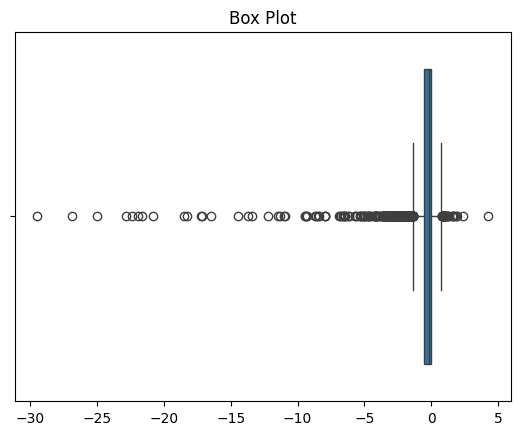

In [13]:
# Creating the box plot
sns.boxplot(x=whole_result)

# Adding title
plt.title('Box Plot')

# Displaying the plot
plt.show()

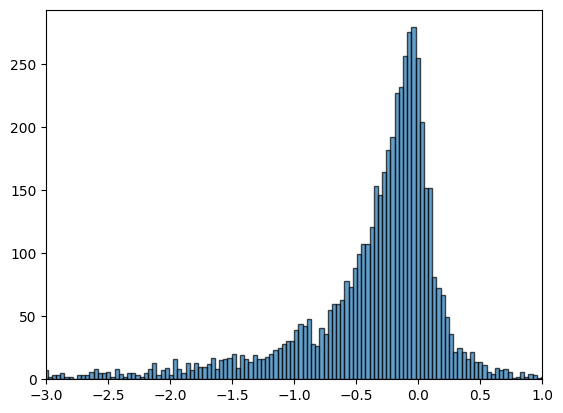

In [23]:
plt.hist(whole_result, bins=1000, edgecolor='black', alpha=0.7)
plt.xlim(-3, 1) 
plt.show()

# simplified sentence

In [24]:
from scipy.stats import ttest_rel

# Extract the values for edited_NLL_simplified and edited_NLL
edited_NLL_simplified = [result['edited_NLL_simplified'] for result in negation_results]
edited_NLL = [result['edited_NLL'] for result in negation_results]

# Calculate the difference between edited_NLL_simplified and edited_NLL
difference = [simplified - original for simplified, original in zip(edited_NLL_simplified, edited_NLL)]

# Perform the Wilcoxon signed-rank test
stat, p = wilcoxon(difference, alternative='less')

# Print the results
print(f'Statistics={stat}, p={p}')

# Interpret the result
alpha = 0.05  # significance level
if p < alpha:
    print("Reject the null hypothesis - Suggest the data is significantly less than 0")
else:
    print("Fail to reject the null hypothesis - No suggestion that the data is significantly less than 0")

Statistics=500235.0, p=5.258271138345113e-41
Reject the null hypothesis - Suggest the data is significantly less than 0


In [25]:

a = sum([i <= 0 for i in difference])
a/len(difference)

0.6238738738738738

In [26]:
mean_value = np.mean(difference)
print("Mean value:", mean_value)

Mean value: -1.7253948040809985


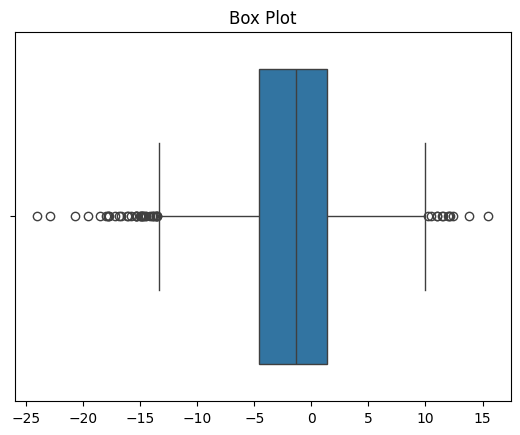

In [27]:
# Creating the box plot
sns.boxplot(x=difference)

# Adding title
plt.title('Box Plot')

# Displaying the plot
plt.show()

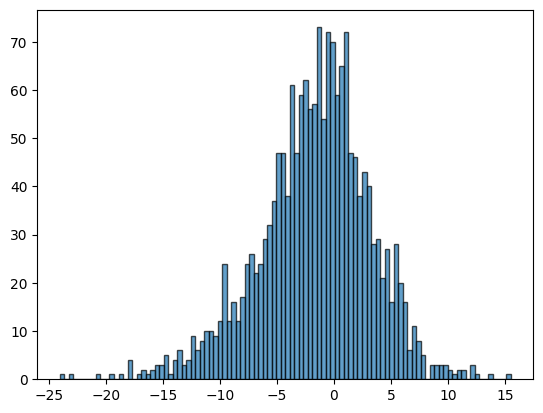

In [35]:
plt.hist(difference, bins=100, edgecolor='black', alpha=0.7)
# plt.xlim(-3, 1) 
plt.show()